In [61]:
# Import libraries
import math
from pandas_datareader import data as pdr
import yfinance as yfin
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# Use a custom plot style
plt.style.use("fivethirtyeight")

In [62]:
# Get stock quote running from the start of the GOOGL data to yesterday.
# Later we will predict today's adjusted closing price.
yfin.pdr_override()
df = pdr.get_data_yahoo('GOOGL', start='2007-02-14', end='2023-06-09')
#show dataframe
print(df)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2007-02-14   11.511512   11.739990   11.491992   11.659910   11.659910   
2007-02-15   11.661662   11.664915   11.529530   11.548298   11.548298   
2007-02-16   11.581582   11.765516   11.563063   11.760260   11.760260   
2007-02-20   11.723473   11.830581   11.629379   11.814314   11.814314   
2007-02-21   11.757758   11.978979   11.705205   11.908408   11.908408   
...                ...         ...         ...         ...         ...   
2023-06-02  123.989998  126.150002  123.760002  124.669998  124.669998   
2023-06-05  124.010002  127.430000  123.839996  126.010002  126.010002   
2023-06-06  126.010002  128.289993  125.360001  127.309998  127.309998   
2023-06-07  126.970001  129.039993  122.120003  122.500000  122.500000   
2023-06-08  122.230003  123.230003  121.239

In [63]:
# For rows and columns in data
df.shape

(4108, 6)

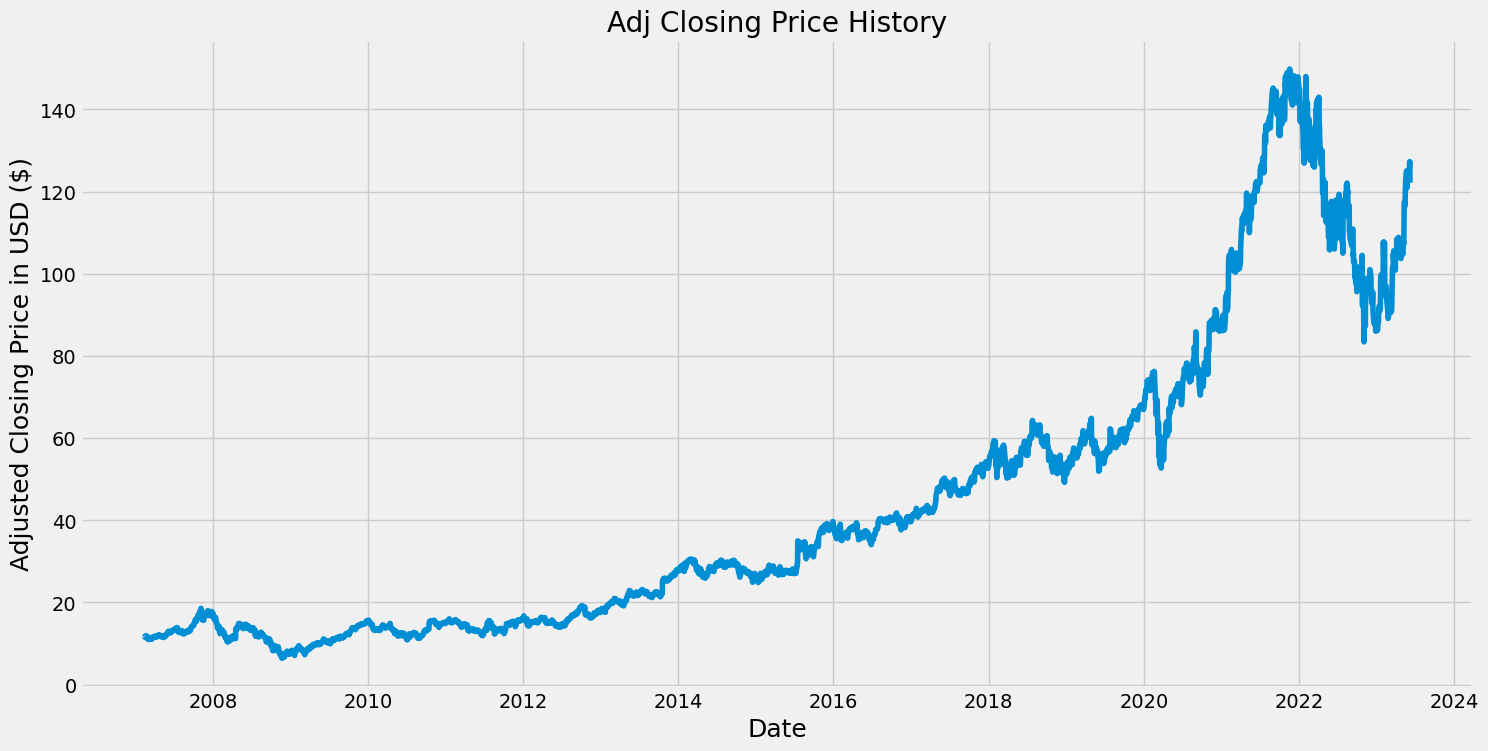

In [64]:
# Visualize adjusted closing price history of GOOGL
plt.figure(figsize=(16,8))
plt.title('Adj Closing Price History')
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adjusted Closing Price in USD ($)', fontsize = 18)
plt.show()

In [65]:
# Create a new dataframe with the 'Adj Close' column
data = df.filter(['Adj Close'])
# Convert data to a numpy array
dataset = data.values
# Get number of rows to train the model. Setting to .8 takes only the first
# 80% of the data and math.ceil rounds up the product.
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

3287

In [66]:
# Scale the data for processing.
scaler = MinMaxScaler(feature_range=(0,1))  #value between 0 and 1
scaled_data = scaler.fit_transform(dataset)  #holds scaled data

In [67]:
# Show the first and last values of the scaled array
scaled_data

array([[0.03638502],
       [0.03560667],
       [0.03708482],
       ...,
       [0.84289315],
       [0.8093497 ],
       [0.80683917]])

In [68]:
# Create the training dataset and scaled training dataset
train_data = scaled_data[0:training_data_len,:]
# Split the data into x_train and y_train datasets first by creating empty lists
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])   # will contain past 60 values indexed from 0
  y_train.append(train_data[i, 0])        # will contain 61st value (at position 60)

In [69]:
# if i<= 60:
#     print(x_train)
#     print(y_train)
# print()

In [70]:
# Convert x_train and y_train to numpy arrays for LSTM model training
x_train, y_train = np.array(x_train), np.array(y_train)

In [71]:
# Reshape the data (LSTM expects 3-dimensional, not 2-dimensional, data)
# Check number of rows and columns
x_train.shape

(3227, 60)

In [72]:
# Reshape x_train with 3227 samples (# of rows, found in first value of x_train.shape), 
# 60 real-time steps (# of columns, found in second value of x_train.shape), 
# and 1 feature (Adj Close)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(3227, 60, 1)

In [73]:
# Build the LSTM model's architecture
model = Sequential()
# Add the LSTM layer with 50 neurons, return_sequences as True because we'll use
# another LSTM layer, and input shape as number of time steps (60) and 1 feature
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Add second and final LSTM layer, also with 50 neurons
model.add(LSTM(50, return_sequences=False))
# Add dense layer with 25 neurons
model.add(Dense(25))
# Add second dense layer with a single neuron
model.add(Dense(1))

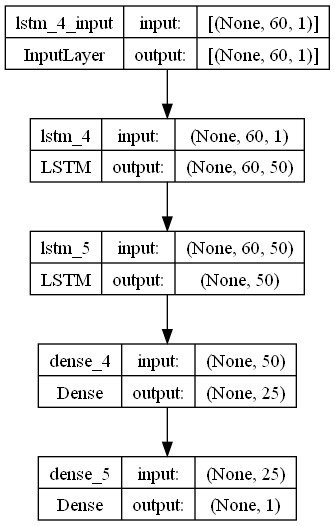

In [74]:
# Visualize our model's architecture
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [75]:
# Compile the model with adam optimizer (used to improve upon the loss function)
# and mean squared error loss function (to measure model's training performance)
model.compile(optimizer='adam', loss='mean_squared_error')

In [76]:
# Train the model with 1 epoch (single iteration of entire dataset being passed forward and backward)
model.fit(x_train, y_train, batch_size=1, epochs=1)

3227/3227 [==============================] - 164s 48ms/step - loss: 2.4487e-04


In [77]:
# Create the testing dataset
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60:,:]
# Create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])  

In [78]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [79]:
# Reshape the test data to 3 dimensions
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [80]:
# Get models predicted adjusted closing price values.
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)    # unscaling the values afterward.

26/26 [==============================] - 3s 38ms/step


In [82]:
# Get the root mean squared error (RMSE), a common measure of error
rmse =np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

6.35226616332085

C:\Users\radhe\AppData\Local\Temp\ipykernel_8664\718550896.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions   # create new column in valid object


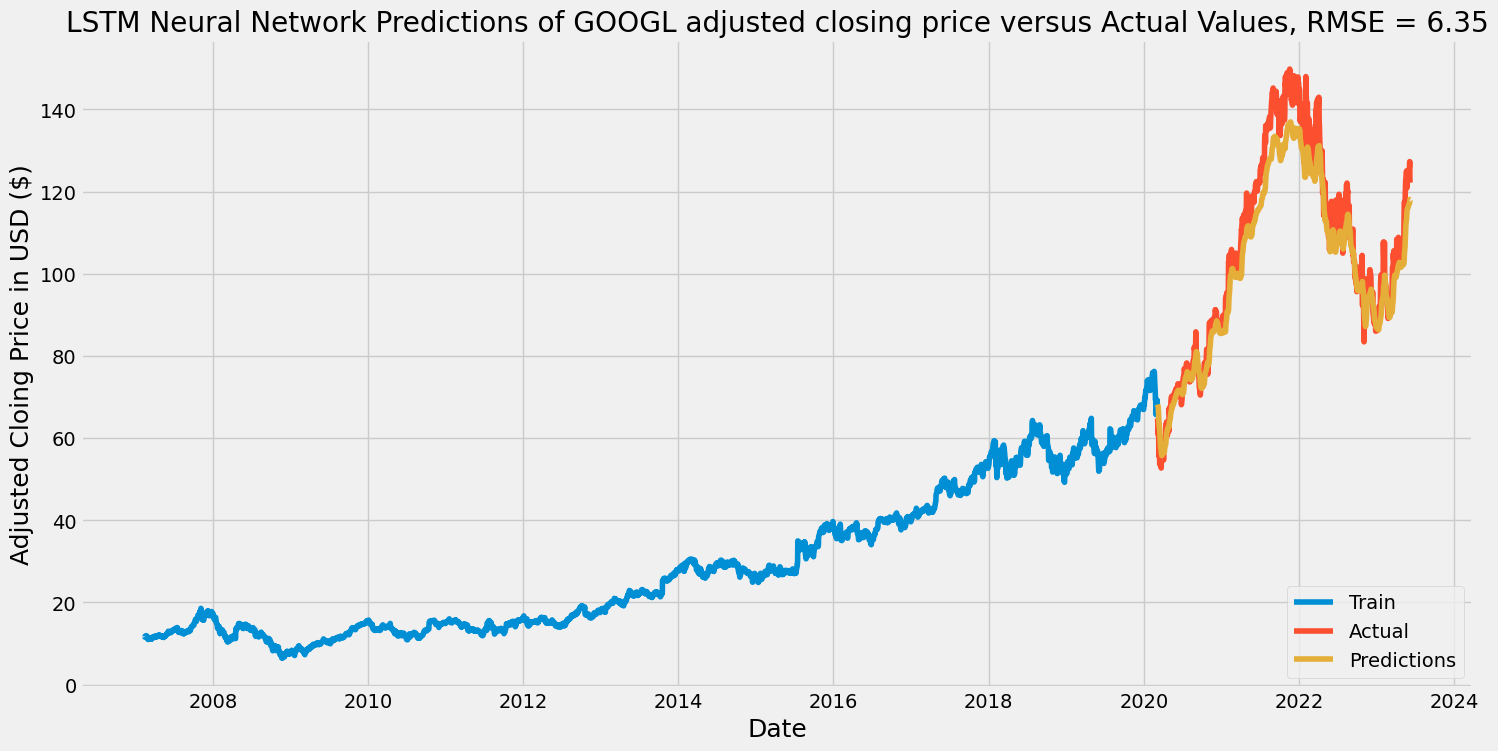

In [83]:
# Plot the data
train = data[:training_data_len]     # runs from zero to max of training data
valid = data[training_data_len:]     # runs from post-training data to end
valid['Predictions'] = predictions   # create new column in valid object
plt.figure(figsize=(16,8))
plt.title('LSTM Neural Network Predictions of GOOGL adjusted closing price versus Actual Values, RMSE = 6.35')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adjusted Cloing Price in USD ($)', fontsize = 18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

In [84]:
# Show the actual versus predicted prices via df we created containing each
valid

,Adj Close,Predictions
Date,,
2020-03-06,64.787003,68.188118
2020-03-09,60.789501,67.561043
2020-03-10,63.758499,66.449303
2020-03-11,60.544998,65.653244
2020-03-12,55.577499,64.686043
...,...,...
2023-06-02,124.669998,116.867882
2023-06-05,126.010002,117.112877
2023-06-06,127.309998,117.520638


In [85]:
# Predicting june 10th adjusted closing price 
# Get the quote
googl_quote = pdr.get_data_yahoo('GOOGL', start='2007-02-14', end='2023-06-09')
# Create a new fataframe
new_df = googl_quote.filter(['Adj Close'])
# Get last 60 day closing price values and convert to an array
last_60_days = new_df[-60:].values
# Scale data
last_60_days_scaled = scaler.transform(last_60_days)
# Create empty list
X_test = []
# Append scaled past 60 days
X_test.append(last_60_days_scaled)
# Convert to numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 62ms/step
[[117.78595]]


In [86]:
# june 10th's actual adjusted closing price
googl_quote2 = pdr.get_data_yahoo('GOOGL', start='2023-06-10', end='2023-06-10')
print(googl_quote2['Adj Close'])

[*********************100%***********************]  1 of 1 completed
Date
2023-06-09    122.230003
Name: Adj Close, dtype: float64
